<a href="https://colab.research.google.com/github/SourLemon23/brain-tumor-diagnosis/blob/master/brain_tumor_diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
import matplotlib.pyplot as plt

In [2]:
# Authorize access to mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Initialize dataset directories (Google Drive)
training_dir   = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/training'
validation_dir = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/validation'
testing_dir    = r'/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing'

In [4]:
# Store all testing images in a list
testing_img_paths = []

for root, dirs, files in os.walk(testing_dir):
    for filename in files:
        testing_img_paths.append(os.path.abspath(os.path.join(root, filename)))

# Randomize the list
random.shuffle(testing_img_paths)

# Choose a random, unseen image as the testing image
# testing_image = random.choice(testing_img_paths)
# print(testing_image)

In [5]:
# Initialize constants
classes = ['glioma', 'meningioma', 'pituitary']
img_width, img_height = 150, 150
target_size = (img_width, img_height)
input_shape = (img_width, img_height, 3)

batch_size = 20
epochs = 5

In [6]:
# Augment data
'''training_data_gen = ImageDataGenerator(rescale=1./255,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True)'''

training_data_gen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.15,
                                   rotation_range=360,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   validation_split=0.15,
                                   shear_range=0.15)

validation_data_gen = ImageDataGenerator(rescale=1./255)

In [7]:
# Split data
training_generator = training_data_gen.flow_from_directory(training_dir,
                                                           target_size=target_size,
                                                           class_mode='categorical',
                                                           batch_size=batch_size,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               target_size=target_size,
                                                               class_mode='categorical',
                                                               batch_size=batch_size,
                                                               shuffle=False)

Found 2460 images belonging to 3 classes.
Found 105 images belonging to 3 classes.


In [8]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

In [9]:
! pip install efficientnet
import efficientnet.tfkeras as efn
img_shape = 150
model =efn.EfficientNetB4(weights='noisy-student', include_top=False, input_shape=input_shape)
  
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
#x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(3, activation="softmax")(x)
model = Model(inputs=model.input, outputs=predictions)


     |████████████████████████████████| 51kB 3.9MB/s 
71680000/71678424 [==============================] - 2s 0us/step


In [ ]:
# Create a neural network
def create_model():
    model = Sequential()

    model.add(ResNet50(include_top=False, weights='imagenet', input_shape=input_shape))
    # model.layers[0].trainable = False
    model.add(Dropout(0.5))

    model.add(Conv2D(16, (3, 3), activation = 'relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(training_generator.num_classes, activation='softmax'))

    return model

In [ ]:
# Print an overall summary of the model
def print_model_summary(model):
    model.summary()

In [ ]:
# Configure model
def compile_model(model):
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
# Train the model
def fit_model(model):
    history = model.fit(training_generator,
                        epochs=epochs,
                        steps_per_epoch=(training_generator.n/batch_size),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/batch_size))
    
    return history

In [ ]:
# Plot and evaluate the model
def evaluate_model(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [ ]:
# # Classify a tumor from an MRI scan
# def classify_tumor(model, testing_img_paths):
#     for i, img_path in enumerate(testing_img_paths):
#         img = load_img(
#             img_path,
#             target_size=target_size)

#         img_array = img_to_array(img)
#         img_array = preprocess_input(img_array)
#         img_array = img_array.reshape((-1, 150, 150, 3))

#         predictions = model.predict(img_array)
#         class_num = predictions.argmax()

#         network_percent_confidence = str(np.max(predictions) * 100)[:4] + '%'
#         network_prediction = classes[class_num].capitalize()

#         font = {'family': 'DejaVu Sans',
#                 'color' : 'red',
#                 'weight': 'heavy',
#                 'size'  :  10}

#         print(f'MRI Scan #{i+1})')

#         print(testing_img_paths[i])
        
#         plt.imshow(img)
#         plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font)
#         plt.show()

In [ ]:
model = create_model()
compile_model(model)
print_model_summary(model)

# history = fit_model(model)
# evaluate_model(history)

# classify_tumor(model, testing_img_paths)

94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 16)          294928    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 3, 16)          64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________

Epoch 1/5
123/123 [==============================] - 893s 7s/step - loss: 0.5477 - accuracy: 0.7833 - val_loss: 3.6954 - val_accuracy: 0.3238
Epoch 2/5
123/123 [==============================] - 29s 235ms/step - loss: 0.3461 - accuracy: 0.8667 - val_loss: 1.1504 - val_accuracy: 0.3333
Epoch 3/5
123/123 [==============================] - 29s 233ms/step - loss: 0.2793 - accuracy: 0.8927 - val_loss: 2.5560 - val_accuracy: 0.3143
Epoch 4/5
123/123 [==============================] - 29s 235ms/step - loss: 0.2837 - accuracy: 0.8963 - val_loss: 5.4846 - val_accuracy: 0.3333
Epoch 5/5
123/123 [==============================] - 29s 237ms/step - loss: 0.2167 - accuracy: 0.9248 - val_loss: 1.5246 - val_accuracy: 0.4667


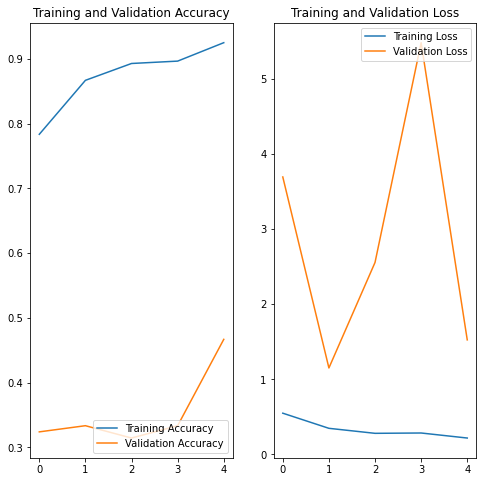

In [ ]:
history = fit_model(model)
evaluate_model(history)

In [ ]:
# training_loss, training_acc = model.evaluate(training_generator, steps=training_generator.n/batch_size)
# validation_loss, validation_acc = model.evaluate(validation_generator, steps=validation_generator.n/batch_size)

# print(f'Training Accuracy: {training_acc}, Training Loss: {training_loss}')
# print(f'Validation Accuracy: {validation_acc}, Validation Loss: {validation_loss}')

In [ ]:
# Classify a tumor from an MRI scan
def classify_tumor(model, testing_img_paths):
    for i, img_path in enumerate(testing_img_paths):
        img = load_img(img_path,
                       target_size=target_size,
                       interpolation='nearest')

        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = img_array.reshape((-1, 150, 150, 3))

        predictions = model.predict(img_array)
        class_num = predictions.argmax()

        print(class_num)

        print(predictions)

        network_percent_confidence = str(np.max(predictions) * 100)[:4] + '%'
        network_prediction = ['glioma', 'meningioma', 'pituitary'][class_num].capitalize()
        # network_prediction = classes[class_num].capitalize()

        font = {'family': 'DejaVu Sans',
                'color' : 'red',
                'weight': 'heavy',
                'size'  :  10}

        print(f'MRI Scan #{i+1})')

        print(testing_img_paths[i])
        
        plt.imshow(img)
        plt.title(f'Network Prediction: {network_prediction} ({network_percent_confidence})', fontdict=font)
        plt.show()

1
[[4.992029e-28 1.000000e+00 0.000000e+00]]
MRI Scan #1)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(53).jpg


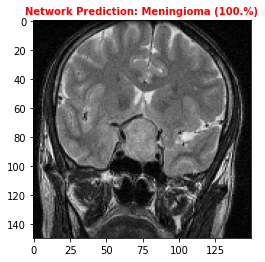

1
[[4.581009e-30 1.000000e+00 0.000000e+00]]
MRI Scan #2)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(76).jpg


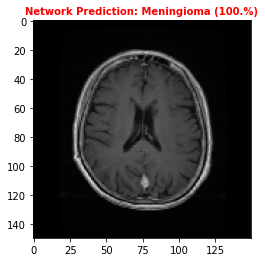

1
[[1.0702415e-34 1.0000000e+00 0.0000000e+00]]
MRI Scan #3)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(56).jpg


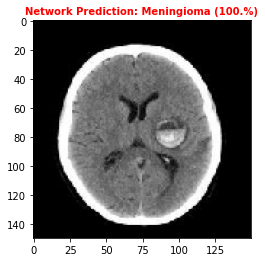

1
[[1.3994679e-26 1.0000000e+00 0.0000000e+00]]
MRI Scan #4)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(79).jpg


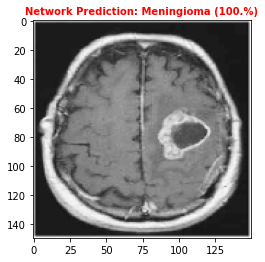

1
[[2.950664e-32 1.000000e+00 0.000000e+00]]
MRI Scan #5)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(94).jpg


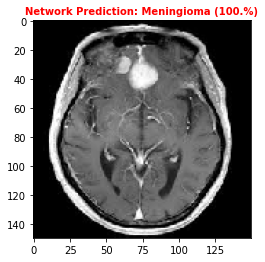

1
[[1.7089403e-30 1.0000000e+00 0.0000000e+00]]
MRI Scan #6)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(88).jpg


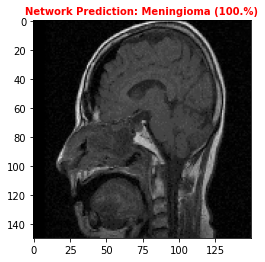

1
[[3.1490036e-32 1.0000000e+00 0.0000000e+00]]
MRI Scan #7)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(85).jpg


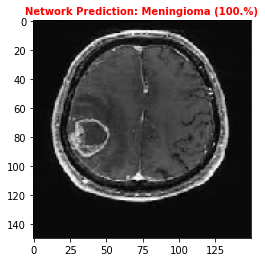

1
[[6.285422e-32 1.000000e+00 0.000000e+00]]
MRI Scan #8)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(69).jpg


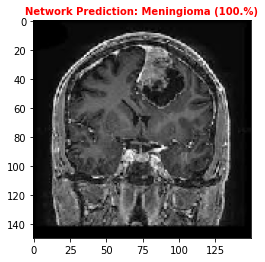

1
[[3.1371503e-29 1.0000000e+00 0.0000000e+00]]
MRI Scan #9)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(81).jpg


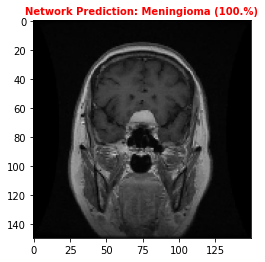

1
[[9.73413e-38 1.00000e+00 0.00000e+00]]
MRI Scan #10)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(97).jpg


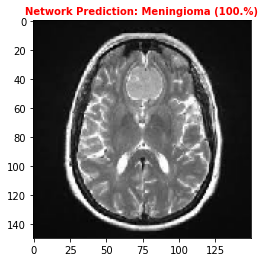

1
[[6.1729615e-23 1.0000000e+00 3.7303957e-35]]
MRI Scan #11)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(85).jpg


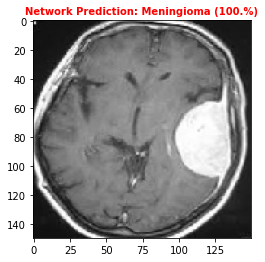

1
[[1.7509416e-23 1.0000000e+00 5.8694976e-35]]
MRI Scan #12)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(71).jpg


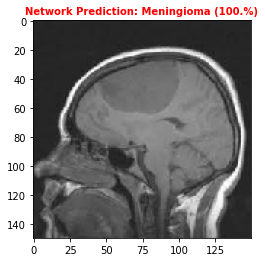

1
[[3.2510002e-30 1.0000000e+00 0.0000000e+00]]
MRI Scan #13)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(73).jpg


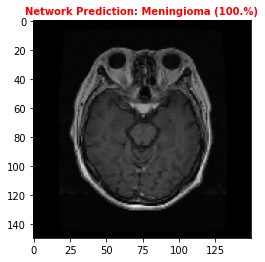

1
[[1.1237247e-24 1.0000000e+00 4.1059564e-35]]
MRI Scan #14)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(66).jpg


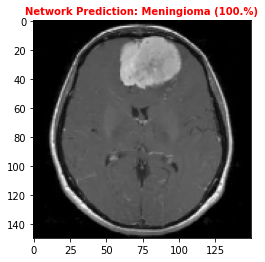

1
[[2.089367e-32 1.000000e+00 0.000000e+00]]
MRI Scan #15)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(125).jpg


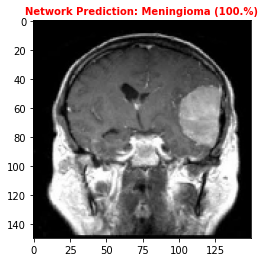

1
[[1.8641615e-28 1.0000000e+00 0.0000000e+00]]
MRI Scan #16)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(59).jpg


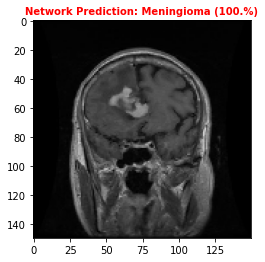

1
[[1.5683927e-28 1.0000000e+00 0.0000000e+00]]
MRI Scan #17)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(61).jpg


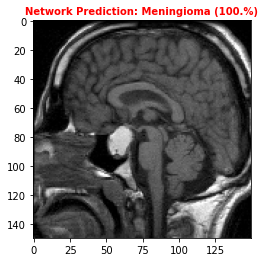

1
[[7.2658147e-31 1.0000000e+00 0.0000000e+00]]
MRI Scan #18)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(79).jpg


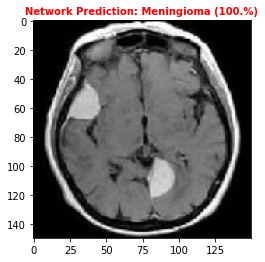

1
[[3.4746517e-31 1.0000000e+00 0.0000000e+00]]
MRI Scan #19)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(81).jpg


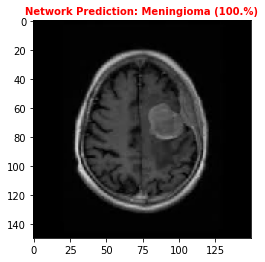

1
[[5.798473e-31 1.000000e+00 0.000000e+00]]
MRI Scan #20)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(66).jpg


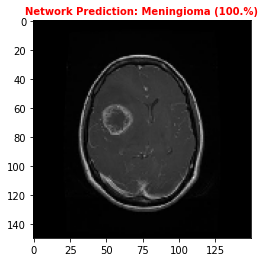

1
[[2.6882736e-30 1.0000000e+00 0.0000000e+00]]
MRI Scan #21)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(68).jpg


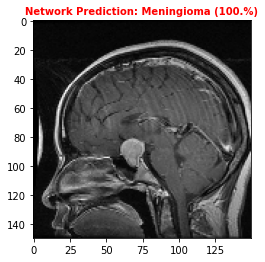

1
[[4.7172453e-35 1.0000000e+00 0.0000000e+00]]
MRI Scan #22)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(109).jpg


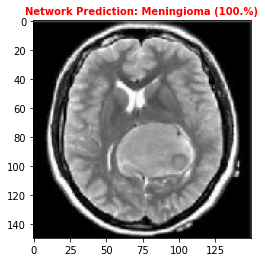

1
[[2.5904511e-22 1.0000000e+00 1.1299039e-35]]
MRI Scan #23)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(97).jpg


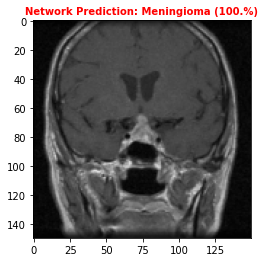

1
[[7.013216e-29 1.000000e+00 0.000000e+00]]
MRI Scan #24)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(94).jpg


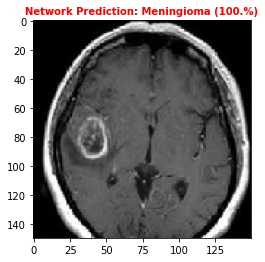

1
[[0. 1. 0.]]
MRI Scan #25)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(107).jpg


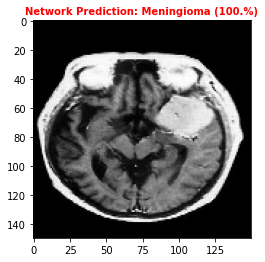

1
[[7.490591e-25 1.000000e+00 0.000000e+00]]
MRI Scan #26)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(66).jpg


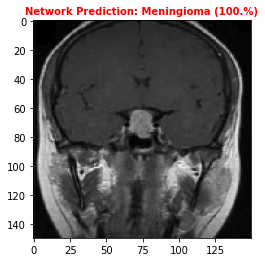

1
[[1.3528207e-24 1.0000000e+00 7.2950337e-38]]
MRI Scan #27)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/glioma/image(57).jpg


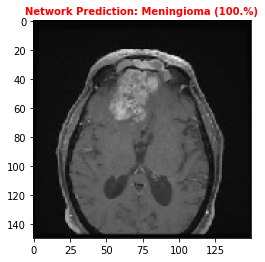

1
[[5.3975827e-30 1.0000000e+00 0.0000000e+00]]
MRI Scan #28)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(96).jpg


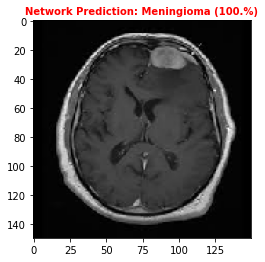

1
[[1.4410870e-24 1.0000000e+00 1.9059894e-36]]
MRI Scan #29)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/meningioma/image(74).jpg


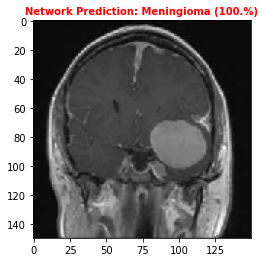

1
[[2.5904511e-22 1.0000000e+00 1.1299039e-35]]
MRI Scan #30)
/content/drive/My Drive/Colab Notebooks/Brain Tumor Diagnosis/brain_tumor_image_set/testing/pituitary/image(96).jpg


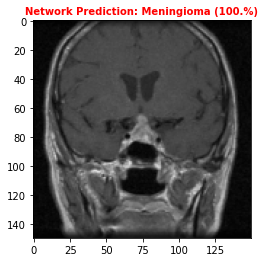

In [ ]:
classify_tumor(model, testing_img_paths)